In [1]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import time
from glob import glob
import numpy as np
from PIL import Image
import torchvision

In [2]:
epochs = 10

In [3]:
from PIL import Image

## Load data - train(product image)

In [4]:
def imread(fname):
    return Image.open(fname)

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
from pathlib import Path

In [7]:
class VAEDataset(Dataset):
    def __init__(self, fpath):
        self.fnames = list(Path(fpath).iterdir())
        self.num_files = len(self.fnames)
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        fname = str(self.fnames[index])
        x = imread(fname)
        x = resize(x)
        x = totensor(x)
        return x, fname

In [8]:
train_ds = VAEDataset('../data/')

In [9]:
len(train_ds)

26512

In [10]:
batch_size = len(train_ds)-1
#batch_size = 128
sz = 124

In [11]:
totensor = transforms.ToTensor()
resize = transforms.Resize(sz)
#x, fname = valid_ds[10]

In [12]:
#train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_ds, batch_size=batch_size)

In [13]:
len(train_loader)

2

In [14]:
x, fname = next(iter(train_loader)) 

In [15]:
x.shape

torch.Size([26511, 3, 124, 124])

In [16]:
x = torch.reshape(x, (26511, 124,124,3))

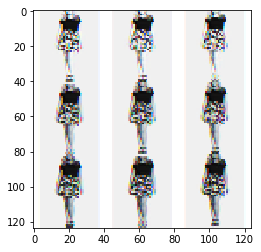

In [17]:
def show(img, title=None):
    plt.imshow(img, interpolation='none')
    if title is not None: plt.title(title)
show(x[:][10])

In [18]:
x.size()

torch.Size([26511, 124, 124, 3])

In [19]:
x_train = x

In [20]:
x_train  = x_train.data.numpy()

## load data - test (insta image)

In [21]:
! rm ../insta_data/.DS_Store
from pathlib import Path
p = Path('../insta_data/')
foldernames = [str(i) for i in p.iterdir()]

filenames = []
for folder in foldernames:
    p = Path(folder)
    filenames += [str(i) for i in p.iterdir() if str(i)[-3:]=='jpg']

rm: ../insta_data/.DS_Store: No such file or directory


In [22]:
class VAEDataset_2(Dataset):
    def __init__(self, fnames):
        self.fnames = fnames
        self.num_files = len(self.fnames)
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        fname = str(self.fnames[index])
        x = imread(fname)
        x = resize(x)
        x = totensor(x)
        return x, fname

In [23]:
valid_ds = VAEDataset_2(filenames)

In [24]:
len(valid_ds)

26035

In [25]:
#batch_size = len(valid_ds)-1
batch_size = 2000
sz = 124

In [26]:
test_loader = DataLoader(valid_ds, batch_size=batch_size)

In [27]:
test_loader

In [28]:
x_ins, fname_ins = next(iter(test_loader)) 

In [29]:
x_ins.shape

torch.Size([2000, 3, 124, 124])

In [30]:
x_ins = torch.reshape(x_ins, (2000, 124,124,3))

In [31]:
x_test = x_ins

In [32]:
x_test  = x_test.data.numpy()

## Autoencoder Model

In [33]:
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [34]:
input_img = Input(shape=(124,124,3))
x = Conv2D(31,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [35]:
autoencoder.fit(x_train, x_train, epochs=3, batch_size=32, callbacks=None )

Epoch 1/3
26511/26511 [==============================] - 726s 27ms/step - loss: 0.0226
Epoch 2/3
26511/26511 [==============================] - 748s 28ms/step - loss: 0.0129
Epoch 3/3
26511/26511 [==============================] - 735s 28ms/step - loss: 0.0113


In [36]:
autoencoder.save('autoencoder.h5')

In [37]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 124, 124, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 31)      868       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 31)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 16)        4480      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 8)         1160      
_________________________________________________________________
encoder (MaxPooling2D)       (None, 16, 16, 8)         0         
__________

In [38]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

In [39]:
encoder.save('encoder.h5')

In [40]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 124, 124, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 31)      868       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 31)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 16)        4480      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 8)         1160      
_________________________________________________________________
encoder (MaxPooling2D)       (None, 16, 16, 8)         0         
Total para

## predict

In [186]:
query = x_test[930] # ins pic we want to match

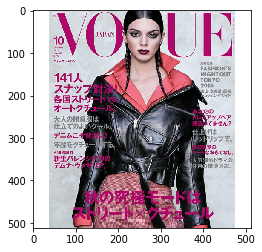

In [185]:
plt.imshow(imread(fname_ins[930]))

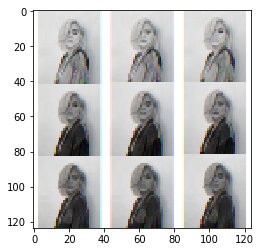

In [115]:
plt.imshow(query.reshape(124,124,3), cmap='gray')

In [116]:
x_train.shape

(26511, 124, 124, 3)

In [47]:
#X_test = np.delete(x_train, 617, axis=0)

In [101]:
codes = encoder.predict(x_train)

In [187]:
query_code = encoder.predict(query.reshape(1,124,124,3))

In [188]:
codes.shape

(26511, 2048)

In [189]:
query_code.shape

(1, 16, 16, 8)

In [190]:
from sklearn.neighbors import NearestNeighbors

In [191]:
n_neigh = 4

In [192]:
codes = codes.reshape(-1, 16*16*8); print(codes.shape)
query_code = query_code.reshape(1, 16*16*8); print(query_code.shape)

(26511, 2048)
(1, 2048)


In [193]:
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)

In [194]:
distances, indices = nbrs.kneighbors(np.array(query_code))

In [195]:
distances

array([[16.60411297, 17.45185219, 17.5220399 , 17.53430734]])

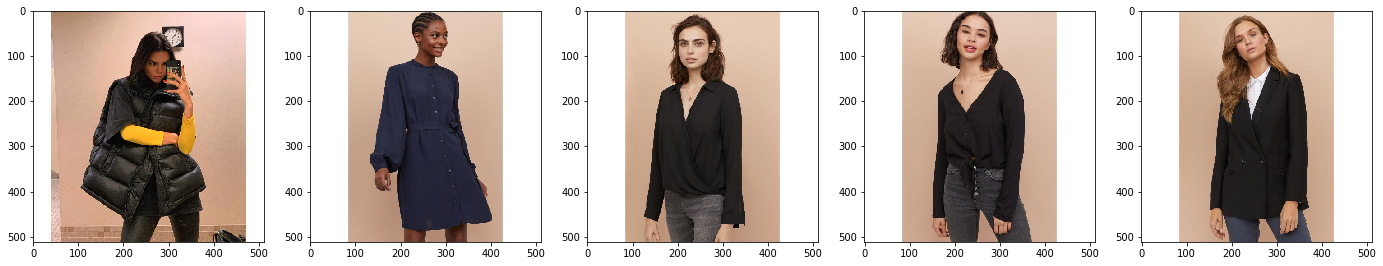

In [91]:
i=2
plt.figure(figsize=(24, 8))
ax = plt.subplot(1, n_neigh+1, 1)
plt.imshow(imread(fname_ins[1213]))
for name in indices[0]:
    ax = plt.subplot(1, n_neigh+1, i)
    plt.imshow(imread(fname[name]))
    i+=1

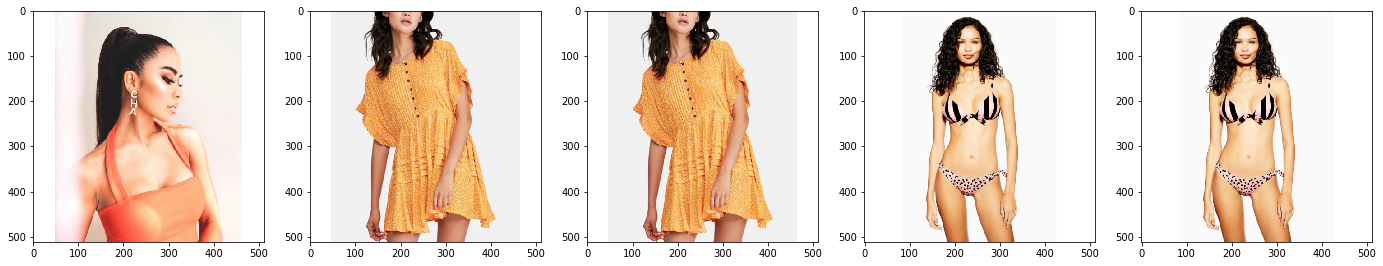

In [112]:
i=2
plt.figure(figsize=(24, 8))
ax = plt.subplot(1, n_neigh+1, 1)
plt.imshow(imread(fname_ins[233]))
for name in indices[0]:
    ax = plt.subplot(1, n_neigh+1, i)
    plt.imshow(imread(fname[name]))
    i+=1

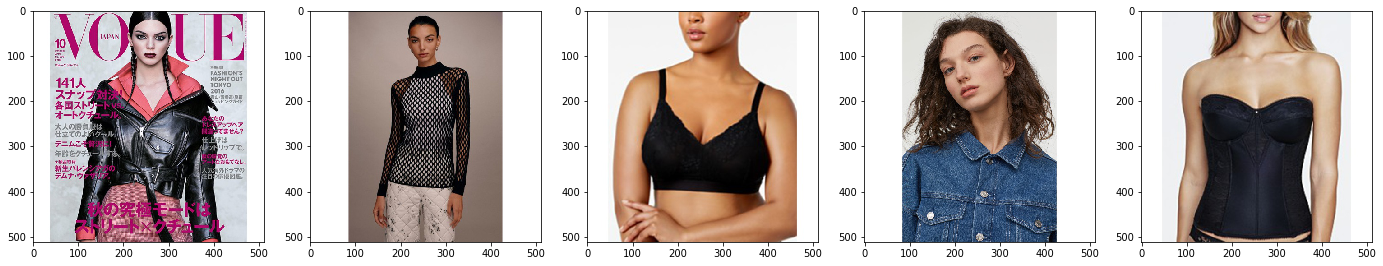

In [197]:
i=2
plt.figure(figsize=(24, 8))
ax = plt.subplot(1, n_neigh+1, 1)
plt.imshow(imread(fname_ins[930]))
for name in indices[0]:
    ax = plt.subplot(1, n_neigh+1, i)
    plt.imshow(imread(fname[name]))
    i+=1